# Singular Value Thresholding  
by Ilya Zharikov

In [111]:
import numpy as np
import time
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def show(filename, y_size=15, x_size=7):
    image= io.imread(filename)
    plt.figure(figsize=(y_size, x_size))
    plt.axis('off')
    plt.imshow(image)
    plt.show()

In [4]:
def sampling_operator(nsamp, dims, seed=1):
    np.random.seed(seed)
    idx = np.random.choice(np.prod(dims), nsamp, replace=False)
    
    return np.vstack(np.unravel_index(idx, dims)).T    

In [5]:
def get_matrix(rank, dims, seed=1):
    np.random.seed(seed)
    M_l = np.random.randn(dims[0], rank)
    M_r = np.random.randn(dims[1], rank)
    
    return M_l.dot(M_r.T)

In [15]:
def get_sampling_data(matrix, omega):
    data = np.zeros(matrix.shape)
    for i in xrange(omega.shape[0]):
        data[omega[i, 0], omega[i, 1]] = matrix[omega[i, 0], omega[i, 1]]
        
    return data

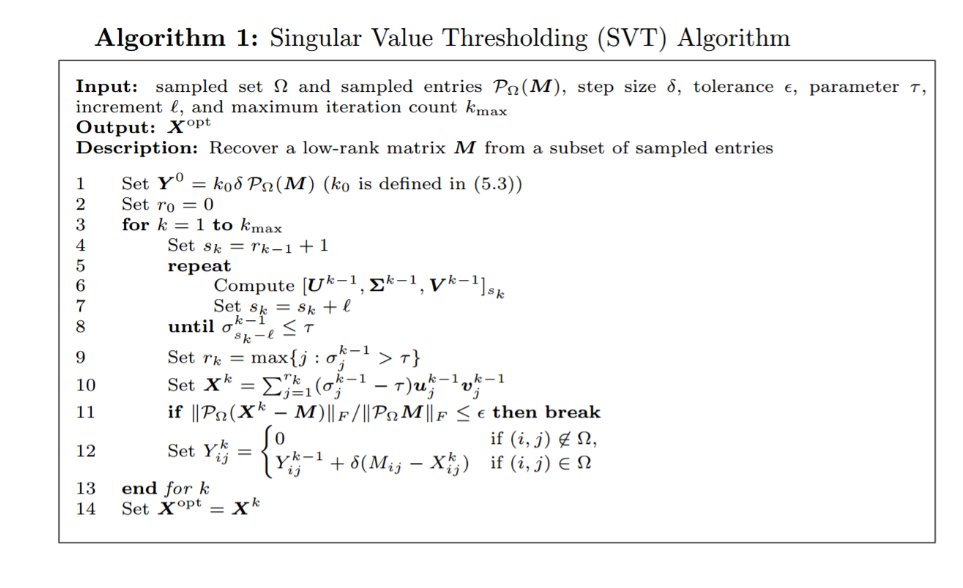

In [3]:
show('SVT.bmp')

In [130]:
def get_report(seed, dims, rank, nsamp, 
               delta, tau, l, max_iter, tol, 
               num_iters, rmse_error, t0, t1, X_opt):
    print 'REPORT:'
    print ''
    print '1| Matrix generation:'
    print '          Random seed: %d' % seed
    print '   Size of the matrix: %d x %d;' % (dims[0], dims[1])
    print '                 Rank: %d;' % rank
    print '           Percentage: %.2f;' % (1. * nsamp / np.prod(dims))
    print '    Number of samples: %d;' % nsamp
    print ''
    print '2| SVT parameters:'
    print '            delta: %.5f;' % delta
    print '              tau: %d;' % tau
    print '  increment_value: %d;' % l
    print '         max_iter: %d;' % max_iter
    print '        tolerance: %.5f;' % tol 
    print ''
    print '3| SVT results:'
    print '   Number of iterations: %d;' % num_iters
    print '                   RMSE: %.5f;' % rmse_error
    print '                   Time: %d min %d sec.' % (int(t1 - t0) // 60, int(t1 - t0) % 60)
    print '                   Rank: %d;' % np.linalg.matrix_rank(X_opt)

In [96]:
def RMSE(A, B):
    return 1. * np.linalg.norm(A - B, 'fro') / np.sqrt(np.prod(A.shape))

In [97]:
def get_k(data, delta, tau):
    return np.ceil(1. * tau / delta / np.linalg.norm(data, 2))

In [98]:
def get_reduced_SVD(matrix, s):
    U, S, V = np.linalg.svd(matrix)
    U = U[:, :s].copy()
    S = S[:s].copy()
    V = V[:s, :].copy()
    
    return U, S, V

In [99]:
def SVT(omega, data, delta, tau, l=5, max_iter=1e4, tol=1e-4):
    norm_of_data = np.linalg.norm(data, 'fro')
    k0 = get_k(data, delta, tau)
    Y = k0 * delta * data
    r = 0
    num_iter = 0
    while num_iter < max_iter:
        s = r + 1
        sigma = tau + 1
        while sigma > tau:
            U, S, V = get_reduced_SVD(Y, s)
            sigma = S[-1]
            s += l
        r = np.sum(S > tau)
        U = U[:, :r].copy()
        S = S[:r].copy()
        S -= tau
        V = V[:r, :].copy()
        X = U.dot(np.diag(S).dot(V))
        X_opt = X.copy()
        
        X = get_sampling_data(X, omega)
        if np.linalg.norm(X - data, 'fro') < tol * norm_of_data:
            break
        
        Y = get_sampling_data(Y, omega)
        Y = Y + delta * (data - X)
        num_iter += 1
    
    return X_opt, num_iter

In [126]:
seed = 1
rank = 10
dims = (1000, 1000)
nsamp = int(np.ceil(0.1 * np.prod(dims)))

omega = sampling_operator(nsamp, dims, seed)
M = get_matrix(rank, dims)
data = get_sampling_data(M, omega)
delta = 1.2 * np.prod(M.shape) / nsamp
tau = 5 * data.shape[0]
l = 5
max_iter = 1e4
tol = 1e-4

t0 = time.time()
X_opt, num_iters = SVT(omega, data, delta, tau, l, max_iter, tol)
rmse_error = RMSE(M, X_opt)
t1 = time.time()

In [131]:
get_report(seed, dims, rank, nsamp, 
           delta, tau, l, max_iter, tol, 
           num_iters, rmse_error, t0, t1, X_opt)

REPORT:

1| Matrix generation:
          Random seed: 1
   Size of the matrix: 1000 x 1000;
                 Rank: 10;
           Percentage: 0.10;
    Number of samples: 100000;

2| SVT parameters:
            delta: 12.00000;
              tau: 5000;
  increment_value: 5;
         max_iter: 10000;
        tolerance: 0.00010;

3| SVT results:
   Number of iterations: 137;
                   RMSE: 0.00059;
                   Time: 1 min 40 sec.
                   Rank: 10;
